In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as atu
from analyze_tools.monte_carlo import get_colliding_time

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average

ROOT = os.path.expanduser('~/OneDrive - Emory/Research Data/mm_polariton/pickle_jar/')

#ROOT = os.path.expanduser('~/OneDrive - Emory/Research data/mm_polariton/pickle_jar')
#assert os.path.isdir(ROOT)

Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.38253012]
 [1.38253012 1.91164659]]
Sigma parameters matrix 
[[1. 

In [2]:
#
# DEFINING FUNCTION
## WARNING: NEXT CELL WILL RUN SIMULATIONS
#


Lxy = 3e7; Lz = 3e3
def get_ArXePair(
    d_arxe, v_ar = 0, h = 0, n_pairs = 1, Lxy=Lxy, Lz=Lz, random_origin = False):
    """
    """
    atoms = AtomsInBox(
        Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
        mass_dict = red.mass_dict)

    v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

    for i in range(n_pairs):
        if i == 0 and not random_origin:
            r0 = np.zeros(3)
        elif random_origin:
            r0 = np.hstack(
                [
                    np.random.uniform(-Lxy/2+100, Lxy/2-100, size = 2), 
                    #np.zeros(2),
                    np.random.uniform(-Lz/2+100, Lz/2-100)]
            )
        atoms.add(
                elements = ["Ar"],
                r = np.array([[0.0, h, -d_arxe/2]]) + r0,
                r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
                )
        
        atoms.add(
                elements = ["Xe"],
                r = np.array([[0.0,0.0,d_arxe/2]]) + r0,
                r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
                )
    
    idxAr = atoms.element_idx(element = "Ar")
    idxXe = atoms.element_idx(element = "Xe")
    epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)
    
    # calculator to the atoms object
    atoms.add_calculator(
        calculator_class = Calculator,
        calculator_kwargs = {
            "epsilon": epsilon_mat, "sigma" : sigma_mat, 
            "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
            "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
        })
    
    atoms.update_distance()
    
    return atoms

def get_field(coup_str, amplitude, T = None, mode = False, Lxy = Lxy, Lz = Lz, field = 'cavity'):
    if mode == 'multi':
        k_vector_int = np.array(
            [[i,0,0] for i in range(1,100)]
            ,dtype=np.float64)
    elif isinstance(mode, int):
        k_vector_int = np.array([[mode,0,0]])
    elif isinstance(mode, list):
        k_vector_int = np.array(
            [[i,0,0] for i in mode], 
            dtype = np.float64)
    else:
        raise Exception('Mode have to be either "multi" or an integer!')
    
    if field == 'cavity':
        VectorPotentialClass = CavityVectorPotential
    elif field == 'free':
        VectorPotentialClass = FreeVectorPotential
    
    Afield = VectorPotentialClass(
            k_vector_int = k_vector_int, amplitude = amplitude,
            Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = coup_str, T = T / red.temp
            )

    return Afield

def get_radprofile(rd, windows = 10):
    Afield = rd['field']
    
    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = atu.profiling_rad(omega, rad_energy)
    
    sorted_idx = np.argsort(omega_profile)

    if windows == 0:
        omega_profile = np.array(omega_profile)[sorted_idx] 
        final_rad_profile = np.array(final_rad_profile)[sorted_idx]
    else:
        omega_profile, final_rad_profile = moving_average(
            np.array(omega_profile)[sorted_idx], 
            np.array(final_rad_profile)[sorted_idx], windows)

    return omega_profile, final_rad_profile

In [3]:
# 
# CALCULATING SPECTRA
# Run simulation of head on collision coupled to FREE field 
# at various total energy as temperature 
# 

result_dict = {}
velocity_dict = {}

M_Xe = red.mass_dict['Xe']

for T in tqdm.tqdm(list(range(25,860,25))):
    
    vt = np.sqrt((T * red.boltzmann / red.epsilon) )
    atoms = get_ArXePair(d_arxe = 6, h = 0.0 , v_ar = vt, n_pairs = 1)
    
    field = get_field(amplitude = 'zero', mode = list(range(1,300)), coup_str = 1, Lz = Lxy, field = 'free' , T = T)
        
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)

    result_dict.update({T : rd})
    velocity_dict.update({T : (vt, vt / np.sqrt(M_Xe))})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:47<00:00,  1.39s/it]


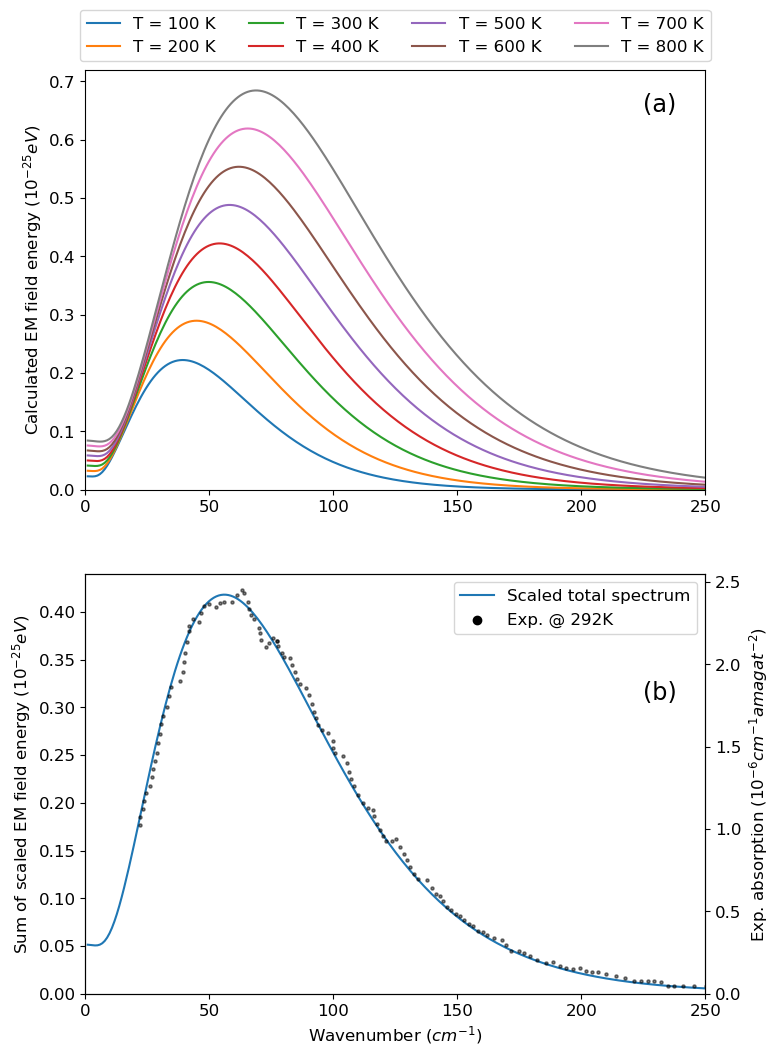

In [21]:
#
# PLOTTING SPECTRA
#

fig,ax = plt.subplots(2, figsize = (8,12))
#fig,ax = plt.subplots(1,2, figsize = (15,5))
plt.rcParams.update({'font.size': 12})

total = 0
total100 = 0

prob_list292 = []
prob_list100 = []

for T in result_dict.keys():
    prob_list292.append(T * np.exp(- T / 292))
    prob_list100.append(T * np.exp(- T / 100))

prob_list292 = np.array(prob_list292)
prob_list292 = prob_list292 / np.sum(prob_list292)
prob_list100 = np.array(prob_list100)
prob_list100 = prob_list100 / np.sum(prob_list100)

for i, (T,rd) in enumerate(result_dict.items()):
    
    omega_profile, final_rad_profile = atu.field_spectra(
        rd, 
        convert_function = {'energy':red.convert_energy, 'wavenumber':red.convert_wavenumber},
        mode = 'std'
    )
    final_rad_profile *= 1e25
    total += final_rad_profile * prob_list292[i]
    total100 += final_rad_profile * prob_list100[i]

    if T % 100 == 0:
        ax[0].plot(
            omega_profile, final_rad_profile, label = 'T = {} K'.format(T), 
            linestyle = 'dashdot' if i >= 35 else None)

ax[1].plot(omega_profile, total, label = 'Scaled total spectrum')
  
tax = ax[1].twinx()
exp_data = pd.read_csv('data/plot-data.csv')
tax.scatter(
    exp_data.loc[:,'x'],
    exp_data.loc[:,' y'],
    s = 5, alpha = 0.5, c = 'black'
)
ax[1].scatter([],[], c = 'black', label = 'Exp. @ 292K')

ax[0].set_ylabel(r"Calculated EM field energy $(10^{-25} eV)$")
ax[1].set_ylabel(r"Sum of scaled EM field energy $(10^{-25} eV)$")
#ax[0].set_xlabel(r"Wavenumber $(cm^{-1})$")
ax[1].set_xlabel(r"Wavenumber $(cm^{-1})$")

tax.set_ylabel(r'Exp. absorption $(10^{-6} cm^{-1} amagat^{-2})$')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate('(b)',xy = (0.9,0.7), xycoords = 'axes fraction', fontsize = 'x-large')

ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=4)
ax[1].legend()

#"""
ax[0].set_ylim(-0.00, 0.72)
ax[1].set_ylim(-0.00, 0.44)
tax.set_ylim(-0.00,2.55)
#"""
ax[0].set_xlim(0.0, 250)
ax[1].set_xlim(0.0, 250)

fig.savefig('figure/manuscript/free_spectrum_singleT.jpeg',dpi = 600, bbox_inches = 'tight')

In [ ]:
# 
# CALCULATING SPECTRA
# Run simulation of head on collision coupled to CAVITY field 
# at various total energy as temperature 
# 
all_result_dict = {}

for coup_str in [10, 20]:
    print(coup_str)
    result_dict = {}
    velocity_dict = {}
    
    M_Xe = red.mass_dict['Xe']
    
    for T in tqdm.tqdm(np.arange(10, 850, 10)):
        
        vt = np.sqrt((T * red.boltzmann / red.epsilon) )
        atoms = get_ArXePair(d_arxe = 6, h = 0.0 , v_ar = vt, n_pairs = 1)
        
        field = get_field(amplitude = 'zero', mode = list(range(1,300)), 
                          coup_str = coup_str * Lxy, Lz = Lz, field = 'cavity' , T = T)
            
        t, rd = single_collision_simulation(
            0, h = 1e-2, atoms = atoms, field = field, 
            max_steps = 5000, verbose = False)
    
        result_dict.update({T : rd})
        velocity_dict.update({T : (vt, vt / np.sqrt(M_Xe))})
        
    all_result_dict.update({coup_str : (result_dict, velocity_dict) })

In [ ]:
save_path = 'pickle_jar/single_collision_zero_cavity'

prompt = input('Do you want to save to path? y/(n)')
if prompt is not 'y': raise Exception

with open(save_path + '/spectra.pkl','wb') as handle:
    pickle.dump(all_result_dict, handle)

In [3]:
#
# PLOTTING SPECTRA
#
save_path = 'pickle_jar/single_collision_boltzmann_cavity'
with open(save_path + '/spectra.pkl','rb') as handle:
    all_result_dict = pickle.load(handle)

fig,ax = plt.subplots(2, figsize = (6,8) )

for i , (coup_str, foo) in enumerate(all_result_dict.items()):
    
    result_dict, velocity_dict = foo
    
    total100_ = 0
    prob_list100_ = []
    
    for T in result_dict.keys():
        prob_list100_.append(T * np.exp(- T / 100))
    
    for j, (T,rd) in enumerate(result_dict.items()):
        
        omega_profile, final_rad_profile = atu.field_spectra(
            rd, convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'abs'
        )
        omega_profile, final_rad_profile = moving_average(omega_profile, final_rad_profile, w = 10)
        final_rad_profile *= 1e2
        total100_ += final_rad_profile * prob_list100_[j]
    
    ax[i].plot(omega_profile, total100_, label = 'Scaled total spectrum in free space')
    ax[i].plot([], [], linestyle = 'dotted', color = 'r', label = 'Scaled total spectrum in the cavity')
    ax[i].set_xlim(0,200)
      
    tax = ax[i].twinx()
    tax.plot(omega_profile, total100, linestyle = 'dotted', color = 'r')

    """
    if i == 0:
        ax[i].set_ylim(0,5.5) # coup_str = 10 L
        tax.set_ylim(0,0.7) # coup_str = 10 L
    elif i == 1:
        ax[i].set_ylim(0,18) # coup_str = 10 L
        tax.set_ylim(0,0.9) # coup_str = 10 L
    elif i == 2:
        ax[i].set_ylim(0,35) # coup_str = 10 L
        tax.set_ylim(0,0.9) # coup_str = 10 L
    """
    
    ax[i].set_ylabel(r"Sum of scaled cavity field energy $(10^{-2} eV)$")
    
    tax.set_ylabel(r"Sum of scaled free field energy $(10^{-25} eV)$")
    
ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=1)

ax[0].annotate(r'$\gamma = 10L$',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate(r'$\gamma = 15L$',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
#ax[2].annotate(r'$\gamma = 20L$',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[2].set_xlabel(r"Wavenumber $(cm^{-1})$")
fig.savefig('figure/manuscript/cavity_spectrum_singleT.jpeg',dpi = 600, bbox_inches = 'tight')

FileNotFoundError: [Errno 2] No such file or directory: 'pickle_jar/single_collision_boltzmann_cavity/spectra.pkl'

In [ ]:
#
# Record (trajectory @ 40K, highest temperature that Ar-Xe complex form, previous temperature)
#

np.random.seed(20)

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = [0.0]
Tlist = list(np.arange(10, 155, 1))

cavity_init = 'boltzmann'
save_path = 'pickle_jar/single_collision_{}_cavity'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

result_dict = {}
for ct in [20, 10]:
    result_dict_ = {}
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        foo = {}
        
        for T in Tlist:
            print("{}/{}".format(T, Tlist[-1]))
            collide_time_list = []
            
            for i in tqdm.tqdm(range(100)):

                vt = np.sqrt((T * red.boltzmann / red.epsilon) )
                # T = K_Ar + K_Xe = 2K_Ar = m_Ar v_Ar^2 (equal kinetic energy of Argon and Xenon)
                atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1, random_origin = True)
                
                field = get_field(
                    amplitude = cavity_init, T = T,
                    mode = list(range(1,260)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
                )
                    
                t, rd = single_collision_simulation(
                    0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                    max_steps = 10000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

                collide_time = get_colliding_time(rd['atoms'], 0)
                
                collide_time_list += collide_time

            #foo.update({T:rd})
            foo.update({T:collide_time_list})
            
        result_dict_.update({h : foo})
    result_dict.update({ct : result_dict_})

with open(save_path + '/collide_time_dict100.pkl','wb') as handle:
    pickle.dump(result_dict, handle)
            

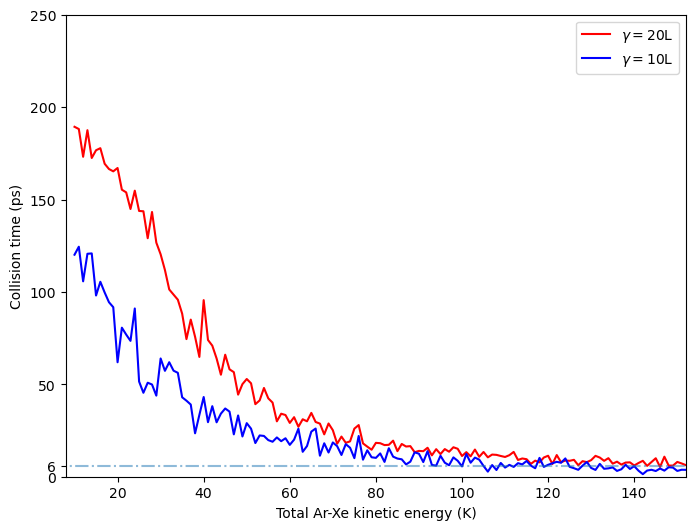

In [21]:
ROOT = 'pickle_jar'
with open(ROOT+'/single_collision_boltzmann_cavity/collide_time_dict100.pkl', 'rb') as handle:
    result_dict = pickle.load(handle)

color_list = ['blue', 'red']
label = {10:"10L", 20:"20L"}

fig,ax = plt.subplots(1, figsize = (8,6))
for i, (coup_str, coup_str_dict) in enumerate(result_dict.items()):
    mean_collide_time = []
    std_collide_time = []
    Tlist = []
    h_dict = coup_str_dict[0.0]
    for t, collide_tlist in h_dict.items():
        Tlist.append(t)
        mean_collide_time.append(np.mean(collide_tlist))
        std_collide_time.append(np.std(collide_tlist))

    mean_collide_time = np.array(mean_collide_time)
    std_collide_time = np.array(std_collide_time)

    if coup_str == 20: i = 1
    elif coup_str == 10: i = 0
    #ax.plot(Tlist, mean_collide_time)
    """
    ax.fill_between(
        np.array(Tlist) + 0.4 * i, 
        mean_collide_time + std_collide_time,
        mean_collide_time - std_collide_time, 
        color = color_list[i],
        alpha = 0.05
    )
    #"""
    ax.plot(
        np.array(Tlist), mean_collide_time, 
        color = color_list[i],
        label = r'$\gamma = ${}'.format(label[coup_str])
    )
    ax.set_ylim(0, 250)
    ax.set_xlim(8, 152)

ax.plot(
    np.linspace(0,170,100),
    [6] * 100, linestyle='dashdot', alpha = 0.5
)

ax.set_yticks(list(ax.get_yticks()) + [6])

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax.set_ylabel(r'Collision time (ps)')

ax.set_xlabel('Total Ar-Xe kinetic energy (K)')
ax.legend()

fig.savefig('figure/manuscript/boltzmann_collision_time.jpeg', dpi = 600, bbox_inches = 'tight')

In [ ]:
#
# Record (trajectory @ 40K, highest temperature that Ar-Xe complex form, previous temperature)
#

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = [0.0, 0.3, 0.6, 0.9, 1.2]
Tlist = list(np.arange(10, 150, 5))

cavity_init = 'boltzmann'
save_path = 'pickle_jar/single_collision_{}_cavity'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

for ct in [20, 15, 10]:
    result_dict = {}
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        foo = {}
        
        for T in tqdm.tqdm(Tlist[::-1]):

            vt = np.sqrt((T * red.boltzmann / red.epsilon) )
            # T = K_Ar + K_Xe = 2K_Ar = m_Ar v_Ar^2 (equal kinetic energy of Argon and Xenon)
            atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1)
            
            field = get_field(
                amplitude = cavity_init, T = T,
                mode = list(range(1,100)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
            )
                
            t, rd = single_collision_simulation(
                0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                max_steps = 10000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

            foo.update({T:rd})
            
        result_dict.update({h : foo})

    with open(save_path + '/coup_str_{}.pkl'.format(ct),'wb') as handle:
        pickle.dump(result_dict, handle)
            

In [ ]:
#
# Simulation of single collisions at various temperature
# The enumeration over all collision temperature will be break if a collision have time < 10ps
# thus suitable for simulation with cavity initiared with zero amplitude
#

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = np.arange(0,1.5,0.1)
Tlist = list(np.arange(10, 120, 1))

cavity_init = 'zero'
save_path = 'pickle_jar/single_collision_{}_cavity_'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

for ct in [20, 1e1]:
    foo = {}

    result_dict = {}
    
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        for T in tqdm.tqdm(Tlist[::-1]):

            vt = np.sqrt((T * red.boltzmann / red.epsilon) )
            atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1)
            
            field = get_field(
                amplitude = cavity_init, T = T,
                mode = list(range(1,260)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
            )
                
            t, rd = single_collision_simulation(
                0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                max_steps = 5000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

            collide_time = get_colliding_time(rd['atoms'], dipole_threshold = 0)[0]

            if collide_time > 10: 
                print('break @ {} K, with collide time {}ps'.format(T, collide_time))
                result_dict.update({h : {'break T':T, 'result_dict':rd}})
                break

    with open(save_path + '/coup_str_{}_.pkl'.format(ct),'wb') as handle:
        pickle.dump(result_dict, handle)

In [ ]:
for i, file in enumerate(glob('pickle_jar/single_collision_zero_cavity_/*')):
    with open(file, 'rb') as handle:
        result_dict = pickle.load(handle)

        if '20' in file: coup_str = 20
        elif '10' in file: coup_str = 10
        elif '15' in file: coup_str = 15

        for h, rd in result_dict.items():
            print("{} & {} & {} \\\ ".format(coup_str, h, rd['break T']))

In [ ]:
result_dict

In [ ]:
fig,ax = plt.subplots(3, figsize = (10,12))


ROOT2 = 'pickle_jar'
for _, file in enumerate(glob(ROOT2 + '/single_collision_boltzmann_cavity/*')):
    print(file)
    if '20' in file: i = 2; cs_annotate = r'$\gamma = 20L$'
    elif '10' in file: i = 0; cs_annotate = r'$\gamma = 10L$'
    elif '15' in file: i = 1; cs_annotate = r'$\gamma = 15L$'
    with open(file, 'rb') as handle:
        result_dict = pickle.load(handle)
        
        #for h, foo in result_dict.items():
        foo = result_dict[0.0]
        collide_time_list = []
        T_list = []
        for T, rd in foo.items():
            collide_time = get_colliding_time(
                rd['atoms'], dipole_threshold = 0)[0]
            
            collide_time_list.append(collide_time)
            T_list.append(T)

        ax[i].plot(T_list, collide_time_list)

        ax[i].set_ylabel('Collision time (ps)')
        
        if i == 2: ax[i].set_xlabel('Collision kinetic energy (K)')

        ax[i].annotate(cs_annotate,xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
            
fig.save_fig()
        

In [ ]:
print('coupling strength & h & total kinetic energy')
for i, (ct, dict1) in enumerate(single_collision_multimode_data.items()):
    for j, (h, data) in enumerate(dict1.items()):
        
        print("{} & {} & {} \\\\ ".format(ct, h, data[-1]))

In [ ]:
h = 1.0
coup_str = 15

atoms = single_collision_multimode_data[coup_str][h][0]['last']['atoms']

coltime = np.array(atm.get_colliding_time(atoms, 0))
result_idx = np.argmax(coltime)
print(coltime[result_idx])

field = single_collision_multimode_data[coup_str][h][0]['last']['field']

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,result_idx]
r_xe = np.array(atoms.trajectory['r'])[:,result_idx + N_pairs]

v_ar = np.array(atoms.trajectory['r_dot'])[:,result_idx]
v_xe = np.array(atoms.trajectory['r_dot'])[:,result_idx + N_pairs]

t = np.array(atoms.trajectory['t'])

In [ ]:
from calculator.function import LJ_potential

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = field.history['t']

fig,ax = plt.subplots(3,figsize = (10,12))
#ax[0].plot(t[200:], d[200:])
ax[0].plot(t, k)
ax[1].plot(t, v)
ax[2].plot(tem[300:], hem[300:])

#ax[0].set_xlim(t[0],t[-1])
ax[0].set_xlim(t[300],t[-1])
ax[1].set_xlim(t[300],t[-1])
ax[2].set_xlim(tem[300],tem[-1])

ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_major_formatter('{x:.0f}')

ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_major_formatter('{x:.0f}')

ax[2].xaxis.set_major_locator(MultipleLocator(5))
ax[2].xaxis.set_major_formatter('{x:.0f}')

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax[0].set_ylabel(r'Kinetic energy ($10^{-3}$ eV)')
ax[1].set_ylabel(r'Potential energy ($10^{-3}$ eV)')
ax[2].set_ylabel(r'Total cavity modes energy ($10^{-3}$ eV)')

ax[2].set_xlabel('Time (ps)')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

#fig.savefig(fig_root + 'energy_breakdown.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
an = importlib.reload(an)

an.single_anime(atoms, index = 0 , N_pairs = N_pairs, save_path = 'figure2/longest_single_anime')